## Dr. Michael Mahesh K Saveetha Engineering College
- michaelmaheshk@gmail.com 
- CNN using Custom Images 
- 19AI413-Deep Learning and Its Applications
- Unit - 2 
- 05-a/05
- EVEN SEM ( Slot: 4Z4-1 & 4U2-1)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [4]:
root = '../Data/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

class_names = train_data.classes


In [5]:
class_names

['CAT', 'DOG']

In [6]:
len(train_data)

18743

In [7]:
len(test_data)

6251

In [8]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

In [9]:
images.shape   # 10 images, 3 colour channel , each channel is 224 x 224

torch.Size([10, 3, 224, 224])

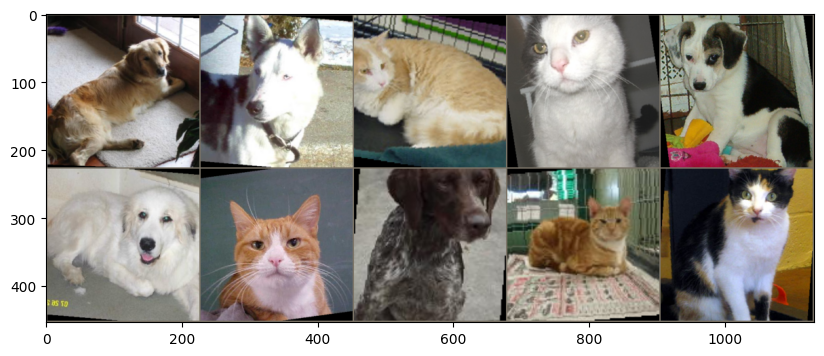

In [10]:
# to display 
im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));
plt.show()

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [14]:
(((224-2)/2)-2)/2

54.5

In [23]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.0001)


In [24]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [25]:
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [26]:
# Training the mmodel

import time
start_time = time.time()



epochs = 3

# optional limits on number of batches
max_trn_batch = 800    # batch 10 images ---> 8000 images
max_tst_batch = 300    # 300 max images 

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # optional Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'Epoch: {i}  loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # optional Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            batch_corr = (predicted == y_test).sum()
            tst_corr += tst_corr + batch_corr

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

    
total_time = time.time() - start_time
print(f'Total Time: {total_time/60} minutes') # print the time elapsed

Epoch: 0  loss: 0.6598962545394897
Epoch: 0  loss: 0.6078444719314575
Epoch: 0  loss: 0.6956881284713745
Epoch: 0  loss: 0.6212964057922363
Epoch: 1  loss: 0.42431721091270447
Epoch: 1  loss: 0.687232494354248
Epoch: 1  loss: 0.5479866862297058
Epoch: 1  loss: 0.5548679828643799
Epoch: 2  loss: 0.77726149559021
Epoch: 2  loss: 0.4330103397369385
Epoch: 2  loss: 0.8303272128105164
Epoch: 2  loss: 0.6556557416915894
Total Time: 2.131151048342387 minutes


In [28]:
torch.save(CNNmodel.state_dict(), 'myImageCNNModel.pt')

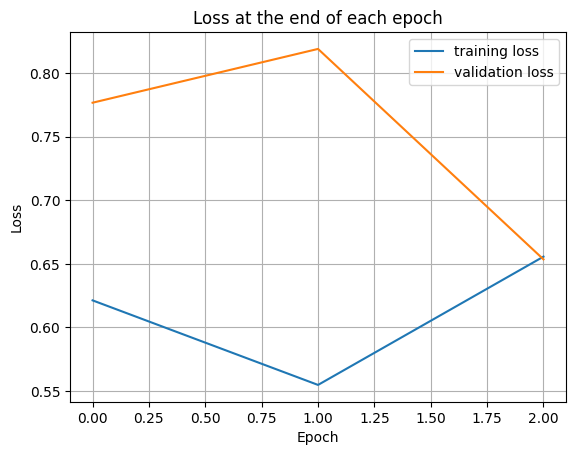

In [29]:
train_losses = [float(loss.detach().numpy()) if torch.is_tensor(loss) else float(loss) for loss in train_losses]
test_losses = [float(loss.detach().numpy()) if torch.is_tensor(loss) else float(loss) for loss in test_losses]

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


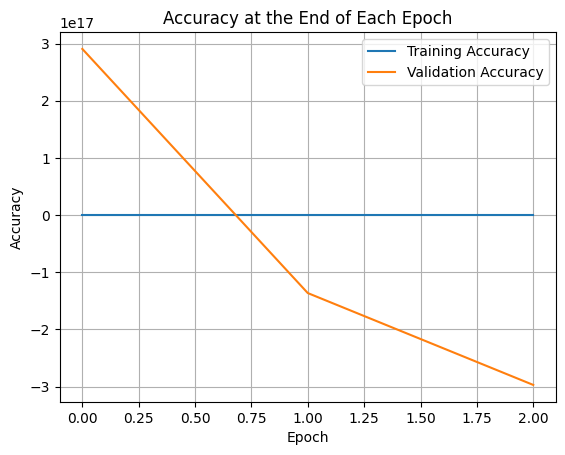

In [30]:
plt.plot([t / 80 for t in train_correct], label='Training Accuracy')
plt.plot([t / 30 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the End of Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
test_correct[-1].item()/3000

-2970499567485180.5

In [32]:
100*test_correct[-1].item()/3000

-2.970499567485181e+17

In [ ]:
# 80